In [1]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from pandas.tseries.offsets import *
import numpy as np
from scipy.stats import norm
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from Backtester.SignalLibrary import Signals
import pandas_datareader.data as web
import wrds
from datetime import datetime 
from scipy.spatial.distance import pdist


Enter your WRDS username [sheha]:fannywu
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [69]:
class PractitionerBS(BaseEstimator, TransformerMixin):
    def __init__(self,
                 y_id='impl_volatility',
                 S_K_id='moneyness',
                 T_id='maturity'):
        self.y_id = y_id
        self.S_K_id = S_K_id
        self.T_id = T_id

    def generate_pbs_features(self, data):

        if data.ndim > 1:
            Intercept = np.ones(data.shape[0])
            S_K = data[:, 0]
            T_365 = data[:, 1] / 365
        else:
            Intercept = np.ones(1)
            S_K = data[0]
            T_365 = data[1] / 365

        S_K_2 = S_K**2
        T_365_2 = T_365**2
        S_K_T_365 = S_K * T_365
        X_ = np.vstack([Intercept, S_K, S_K_2, T_365, T_365_2, S_K_T_365]).T
        return X_

    def fit(self, X, y):
        self.X_ = self.generate_pbs_features(X)
        self.y_ = np.log(y.copy())
        X_, y_ = check_X_y(self.X_, self.y_)
        self.params = (np.linalg.inv(self.X_.T.dot(self.X_)) \
                                    @ (self.X_.T.dot(self.y_))).\
                                            reshape(-1,1)
        return self

    def predict(self, X):

        check_is_fitted(self)
        X_ = check_array(X, ensure_2d=False)
        X_f = self.generate_pbs_features(X_)
        return np.exp(X_f @ self.params)


def d1(S, K, T, r, q, sigma):
    return (np.log(S / K) +
            (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


def d2(S, K, T, r, q, sigma):
    return d1(S, K, T, r, q, sigma) - sigma * np.sqrt(T)


def bs_call(S, K, T, r, q, sigma):
    return S * norm.cdf(d1(S, K, T, r, q, sigma)) * np.exp(-q*T) \
            - K * np.exp(-r * T) * norm.cdf(d2(S, K, T, r, q, sigma))


def bs_put(S, K, T, r, q, sigma):
    return K * np.exp(-r * T) * norm.cdf(-d2(S, K, T, r, q, sigma)) \
            - S * norm.cdf(-d1(S, K, T, r, q, sigma)) * np.exp(-q*T)


def call_delta(S, K, T, r, q, sigma):
    return norm.cdf(d1(S, K, T, r, q, sigma))


def put_delta(S, K, T, r, q, sigma):
    return -norm.cdf(-d1(S, K, T, r, q, sigma))


def is_third_friday(d):
    #d = datetime.strptime(s, '%b %d, %Y')
    return d.weekday() == 4 and 15 <= d.day <= 21


def delta_strike(delta, S, T, r, sigma):
    return S/np.exp(scs.norm.ppf(delta) * (sigma * np.sqrt(T))\
                    - (r + 0.5*sigma**2)*T)


def calc_option_returns(df):
    return df['del_price'].divide(df['price_lag'], axis=0)
    
def calc_hedged_excess_returns(df, scalar='hedged_spot'):

    dol_pnl = df['del_price'].subtract(df['price_lag'].multiply(
        df['rf'] / 252)).subtract(df['delta_lag'].multiply(
            df['del_F'], axis=0))
    
    if scalar is 'spot':
        return dol_pnl.divide(df['close_lag'])
    
    elif scalar is 'hedged_spot':
        if df['cp_flag'].unique() == 'C':
            return dol_pnl.divide(
                    (df['delta_lag'].multiply(df['close_lag'])).\
                    subtract(df['price_lag'])
                    )
        
        elif df['cp_flag'].unique() == 'P':
            return dol_pnl.divide(
                    df['price_lag'].\
                    subtract(df['delta_lag'].multiply(df['close_lag']))
                    )
    else:
        return dol_pnl

In [4]:
# def query_options(year, secid):
#     query =  """
#              select a.secid, a.date, a.symbol,
#              a.exdate, a.cp_flag, a.strike_price/1000 as strike_price,
#              a.best_bid, a.best_offer, a.volume, a.open_interest, a.impl_volatility,
#              a.delta, a.gamma, a.vega, a.theta, a.optionid,a.exdate-a.date as DTM,
#              abs(b.close) as close, b.cfadj
#              from optionm.opprcd{0} as a, optionm.secprd as b
#              where a.date=b.date
#              and a.secid={1}
#              and a.volume>0 and a.impl_volatility>0
#              and a.best_bid<a.best_offer and a.best_bid>0
#              and a.am_settlement=0
#              and a.secid=b.secid 
#              order by a.date, a.secid, a.exdate, a.strike_price;
#              """.format(year, secid)


def query_options(year, secid):
    query =  """
             select a.secid, a.date, a.symbol,
             a.exdate, a.cp_flag, a.strike_price/1000 as strike_price,
             a.best_bid, a.best_offer, a.volume, 
             a.open_interest, a.impl_volatility, a.delta,
             a.gamma, a.vega, a.theta,
             a.optionid, a.exdate-a.date as DTM, a.am_settlement
             from optionm.opprcd{0} as a
             where a.secid={1}
             order by a.date, a.secid, a.exdate, a.strike_price;
             """.format(year, secid)
    
    return db.raw_sql(query)
#  and ((a.strike_price/(1000*abs(b.close))>=1 and a.cp_flag='C')
#  or (a.strike_price/(1000*abs(b.close))<1 and a.cp_flag='P'))

ticker_query = """
               select a.secid, a.ticker,a.cusip, a.index_flag
               from optionm.securd as a
               """
# secids = db.raw_sql(ticker_query)
#secids.to_pickle('secids.pkl')
secids = pd.read_pickle('secids.pkl')

rf_df = Signals.signal_get_data('US0003M Index', 'PX_LAST', '19900101').pull()
# web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start='19800101')[0]['RF']
rf_df = rf_df.to_frame('rf').shift(1).reset_index()
# rf_df.rename(columns={'Date':'date'}, inplace=True)
rf_df['rf'] = rf_df['rf']/100

fut_price = Signals.signal_get_data('SP1 A:03_0_R Index', 'PX_LAST', '19900101').pull()
spot_price = Signals.signal_get_data('SPX Index', 'PX_LAST', '19900101').pull()
dy_df = Signals.signal_get_data('.SPXDIV G Index', 'PX_LAST', '20000101').pull()/100
dy_df = dy_df.to_frame('div').reset_index()

# ticker = 'SPX'
# security_ids = secids[secids['ticker'] == ticker]['secid'].\
#                                             astype(int).tolist()
# start = 1996
# finish = 2020
# optionmaster_df = pd.DataFrame()
# for year in range(start, finish+1):
#     for idx in security_ids:
#         try:
#             optionmaster_df = pd.concat([optionmaster_df,
#                                          query_options(year, idx)], 
#                                         axis=0)
#         except:
#             continue

# optionmaster_df.to_pickle('optionmaster_df.pkl')
#del optionmaster_df


In [5]:
optionmaster_df = pd.read_pickle('optionmaster_df.pkl')
optionm_df = optionmaster_df.copy()
del optionmaster_df

optionm_df['date'] = pd.to_datetime(optionm_df['date'])
optionm_df['exdate'] = pd.to_datetime(optionm_df['exdate'])
optionm_df['date_me'] = optionm_df['date'] + MonthEnd(0)
optionm_df['maturity'] = (optionm_df['exdate'] - optionm_df['date']).dt.days

am_settle_ix = optionm_df['am_settlement'] == 1
optionm_df.loc[am_settle_ix,'maturity'] = optionm_df.loc[am_settle_ix,'maturity'] - 1 

optionm_df = optionm_df.merge(rf_df.merge(dy_df, how='left',on='date'),
                              how='left', on='date')
optionm_df = optionm_df.merge(spot_price.to_frame('close').reset_index(), 
                              how='left', on='date')

optionm_df['moneyness'] = np.where(optionm_df['cp_flag'] == 'C',
                                   optionm_df['close']/optionm_df['strike_price'],
                                   optionm_df['strike_price']/optionm_df['close'])
# optionm_df = optionm_df[optionm_df['cp_flag'] == 'P'].copy()
optionm_df['maturity_idx'] = optionm_df['date'].apply(is_third_friday)

In [6]:
optionm_df['price'] = optionm_df[['best_bid','best_offer']].mean(axis=1)
optionm_df['ba_spread'] = optionm_df['best_offer'] - optionm_df['best_bid']
optionm_df['K_S'] = optionm_df['strike_price'].divide(optionm_df['close'])

#(optionm_df['volume'] > 0.0) & 
iv_volume_ix = (optionm_df['impl_volatility'] > 0.0)
optionm_df = optionm_df[iv_volume_ix].copy()

maturity_ix = (optionm_df['maturity'] <= 252)
optionm_df = optionm_df[maturity_ix]

bid_ix = (optionm_df['best_bid'] >= 0.0) & (optionm_df['best_bid'] < optionm_df['best_offer'])
optionm_df = optionm_df[bid_ix]

c_arb_ix = (optionm_df['cp_flag'] == 'C') & (optionm_df['close'] > optionm_df['best_offer']) \
            & (optionm_df['best_offer'] > \
       np.maximum(optionm_df['close'].subtract(optionm_df['strike_price']),0)) 

p_arb_ix = (optionm_df['cp_flag'] == 'P') & (optionm_df['strike_price'] > optionm_df['price']) \
            & (optionm_df['price'] > \
       np.maximum(optionm_df['strike_price'].subtract(optionm_df['close']),0)) 
optionm_df = optionm_df[c_arb_ix | p_arb_ix]

oi_ix = (optionm_df['open_interest'] > 0)
optionm_df = optionm_df[oi_ix]

spread_ix = (((optionm_df['ba_spread'] >= 0.05) & (optionm_df['price'] < 3)) 
                | ((optionm_df['ba_spread'] >= 0.10) & (optionm_df['price'] > 3)))
optionm_df = optionm_df[spread_ix]

optionm_df['strike_price'] = optionm_df['strike_price'].astype(int)

In [7]:
optionm_df['mat_dates'] = np.datetime64('NaT')
third_friday = (optionm_df['maturity_idx'] == True)
optionm_df.loc[third_friday, 'mat_dates'] = optionm_df.loc[third_friday, 'date']
optionm_df['mat_dates'] = optionm_df['mat_dates'].fillna(method='ffill')

rebal_dt = optionm_df[['date','mat_dates']].drop_duplicates().dropna()
rebal_dt['tau'] = (rebal_dt['mat_dates'] - rebal_dt['date']).dt.days
rebal_dt['mat_dates_fwd'] = rebal_dt['mat_dates'].shift(-1)
rebal_dt['rebal_dates'] = np.where(rebal_dt['tau'] == 0,
                                   rebal_dt['mat_dates_fwd'],
                                   rebal_dt['mat_dates'])
optionm_df = optionm_df.merge(rebal_dt[['date','rebal_dates']], 
                              how='left',
                              on='date').dropna()

In [8]:
# close_lag = optionm_df.groupby('date')['close'].last().shift(1).\
#                 to_frame('close_lag').reset_index()
del_f = fut_price.diff().to_frame('del_F').reset_index()
optionm_df.drop(columns='close', inplace=True)
spot_df = spot_price.to_frame('close')
spot_df['del_close'] = spot_df['close'].diff(1)
spot_df['close_lag'] = spot_df['close'].shift(1)
optionm_df = optionm_df.merge(spot_df,
                              on='date',
                              how='left')
spot_df.index.name = None
spot_df['date'] = spot_df.index
optionm_df = optionm_df.merge(del_f,
                              on='date',
                              how='left')

optionm_df['optionid'] = optionm_df['optionid'].astype(int)
optionm_df['del_price'] = optionm_df.groupby(['optionid'])['price'].diff()
optionm_df['price_lag'] = optionm_df.groupby(['optionid'])['price'].shift(1)
optionm_df['delta_lag'] = optionm_df.groupby(['optionid'])['delta'].shift(1)
optionm_df['vega_lag'] = optionm_df.groupby(['optionid'])['vega'].shift(1)
optionm_df['moneyness_round'] = optionm_df['moneyness'].apply(np.round, args=(2,))
optionm_df['moneyness_bucket'] = pd.cut(optionm_df['moneyness_round'],
                                        [0.90, 0.95, 1.00, 1.05, 1.10])
optionm_df['delta_abs'] = optionm_df['delta_lag'].apply(np.round, args=(2,)).apply(np.abs)

options_df = pd.DataFrame()
options_df['Spot'] = spot_df['close_lag'].copy()
dts = optionm_df['mat_dates'][optionm_df['mat_dates'] <= '2020-12-31'].sort_values().unique()

In [71]:
def filter_options(df, delta, delta_eps, dtm_lb, dtm_ub):
    
    delta_ix = (df['delta_abs'] >= (delta - delta_eps)) & \
                (df['delta_abs'] <= (delta + delta_eps))

    pair_start_df = df[delta_ix].copy()
    call_mat_ix = ((pair_start_df['maturity'] >= dtm_lb) & (pair_start_df['maturity'] <= dtm_ub)) & \
                    (pair_start_df['cp_flag'] =='C')
    put_mat_ix = ((pair_start_df['maturity'] >= dtm_lb) & (pair_start_df['maturity'] <= dtm_ub)) & \
                    (pair_start_df['cp_flag'] =='P')

    delta_calls = pair_start_df[call_mat_ix].sort_values(by='delta_abs', 
                                                         ascending=False)[['delta_abs','optionid']]
    delta_puts = pair_start_df[put_mat_ix].sort_values(by='delta_abs', 
                                                       ascending=False)[['delta_abs','optionid']]

    try:
        arr = np.hstack([delta_calls['delta_abs'].values.reshape(-1,1),
                         delta_puts['delta_abs'].values.reshape(-1,1)])
        min_dist = min_distance(arr)
        call_id = delta_calls['optionid'].iloc[min_dist[0]]
        put_id = delta_puts['optionid'].iloc[min_dist[1]]    
    except:
        call_id = delta_calls['optionid'].iloc[0]
        put_id = delta_puts['optionid'].iloc[0]
        
    return call_id, put_id

def process_pnl_df(df, indices):
    
    df['scalar'] = np.where(df['rebal_ix'] == 1, df['close_lag'], np.nan)
    df['scalar'] = df['scalar'].fillna(method='ffill')
    df['dol_pnl'] = (df['del_price'].subtract(df['price_lag'].multiply(
                        df['rf'] / 252)))
    df['%_pnl'] = df['dol_pnl'].divide(df['scalar'])
    df['dol_pnl_hedged'] = calc_hedged_excess_returns(df, None)
    df['%_pnl_hedged'] = df['dol_pnl_hedged'].divide(df['scalar'])
    
    df = df.loc[indices].copy()
    
    return df

def get_index_returns(df, pnl_tag, vega_tag, rebal_tag, vega_exp=0.01, base=1.0):
    
    pnl_df = df.copy()
    pnl_df['n_contracts'] = np.nan
    pnl_df['n_contracts'] = np.where(pnl_df[rebal_tag] == 1,
                                     (vega_exp)/(pnl_df[vega_tag]*0.01), 
                                     pnl_df['n_contracts'])
    pnl_df['n_contracts'] = pnl_df['n_contracts'].fillna(method='ffill')
    pnl_df['mv_cumsum'] = np.nan
    pnl_df['mv_cumsum'].iloc[0] = base + pnl_df[pnl_tag].iloc[0]*pnl_df['n_contracts'].iloc[0]
    pnl_df['mv_cumsum'] = pnl_df['mv_cumsum'].fillna(pnl_df[pnl_tag].multiply(pnl_df['n_contracts'])).\
                            cumsum().shift(1).fillna(method='ffill')

    return (pnl_df[pnl_tag].multiply(pnl_df['n_contracts'])).divide(pnl_df['mv_cumsum'],axis=0)

def get_pnl_df(optionm_df, delta_start, delta_eps, dtm_lb, dtm_ub):
    
    global dts
    cols = ['date', 'dtm', 'cp_flag','price','price_lag','del_price', 'moneyness',
            'delta_lag','vega_lag', 'del_close', 'del_F', 'close', 'close_lag', 'rf']
    call_df = pd.DataFrame()
    put_df = pd.DataFrame()

    for ix in range(1, len(dts)-1):

        delta = delta_start
        dt = dts[ix]
        port_ix = (optionm_df['date'] == dt)
        test_df = optionm_df[port_ix]
        try:
            call_id, put_id = filter_options(test_df, 
                                             delta,
                                             delta_eps,
                                             dtm_lb,
                                             dtm_ub)
        except:    
            delta = delta + 0.05
            call_id, put_id = filter_options(test_df,
                                             delta,
                                             delta_eps,
                                             dtm_lb,
                                             dtm_ub)

        pair_ix = ((optionm_df['date'] >= dts[ix]) & (optionm_df['date'] < dts[ix+1])) & \
                    ((optionm_df['optionid'] == call_id) | (optionm_df['optionid'] == put_id))
        strat_df = optionm_df[pair_ix][cols]
        calls = strat_df[strat_df['cp_flag'] =='C']
        calls['rebal_ix'] = 0
        calls.loc[calls['date'] == dt,'rebal_ix'] = 1
        calls.index = calls['date']
        
        call_df = pd.concat([call_df, calls], axis=0)

        puts = strat_df[strat_df['cp_flag'] =='P']
        puts['rebal_ix'] = 0
        puts.loc[puts['date'] == dt,'rebal_ix'] = 1
        puts.index = puts['date']
        put_df = pd.concat([put_df, puts], axis=0)    
    return call_df, put_df

def min_distance(arr):
    distance = pdist(arr)
    idx = np.asarray(np.triu_indices(len(arr), 1))
    idx = idx[:, np.argmin(distance)]
    return idx

In [72]:
dtm_lb = 55
dtm_ub = 70

otm_call_df, otm_put_df = get_pnl_df(optionm_df, 0.25, 0.06, dtm_lb, dtm_ub)
final_ix = (otm_call_df.index).intersection(otm_put_df.index)
call25D_df = process_pnl_df(otm_call_df, final_ix)
put25D_df = process_pnl_df(otm_put_df, final_ix)

In [73]:
dtm_lb = 55
dtm_ub = 70
atm_call_df, atm_put_df = get_pnl_df(optionm_df, 0.50, 0.06, dtm_lb, dtm_ub)
final_ix = (atm_call_df.index).intersection(atm_put_df.index)
call50D_df = process_pnl_df(atm_call_df, final_ix)
put50D_df = process_pnl_df(atm_put_df, final_ix)

In [100]:
short_vol_df = pd.DataFrame()
base = 500
short_vol_df['call25D_vega'] = call25D_df['vega_lag']
short_vol_df['put25D_vega'] = put25D_df['vega_lag']

short_vol_df['call50D_vega'] = call50D_df['vega_lag']
short_vol_df['put50D_vega'] = put50D_df['vega_lag']

short_vol_df['strangle_vega'] = short_vol_df['call25D_vega'] + short_vol_df['put25D_vega']
short_vol_df['straddle_vega'] = short_vol_df['call50D_vega'] + short_vol_df['put50D_vega']

short_vol_df['rebal_ix_straddle'] = call50D_df['rebal_ix']
short_vol_df['rebal_ix_strangle'] = call25D_df['rebal_ix']

short_vol_df['rebal_ix_atmput'] = put50D_df['rebal_ix']
short_vol_df['rebal_ix_otmput'] = put25D_df['rebal_ix']

short_vol_df['short_straddle_pnl'] = -(put50D_df['dol_pnl_hedged'] + call50D_df['dol_pnl_hedged'])
short_vol_df['r_short_straddle'] = get_index_returns(short_vol_df, 'short_straddle_pnl',
                                                     'straddle_vega', 'rebal_ix_straddle', 0.01, base=1.0)

short_vol_df['short_strangle_pnl'] = -(put25D_df['dol_pnl_hedged'] + call25D_df['dol_pnl_hedged'])
short_vol_df['r_short_strangle'] = get_index_returns(short_vol_df, 'short_strangle_pnl',
                                                     'strangle_vega', 'rebal_ix_strangle', 0.01, base=1.0)

short_vol_df['short_atmput_pnl'] = -put50D_df['dol_pnl'].copy()
short_vol_df['r_short_atmput'] = get_index_returns(short_vol_df, 'short_atmput_pnl',
                                                     'put50D_vega', 'rebal_ix_atmput', 0.001, base=1.0)

short_vol_df['short_otmput_pnl'] = -put25D_df['dol_pnl_hedged'].copy()
short_vol_df['r_short_otmput'] = get_index_returns(short_vol_df, 'short_otmput_pnl',
                                                     'put25D_vega', 'rebal_ix_otmput', 0.01, base=1.0)

short_vol_df['r_vrp_strat'] = short_vol_df[['r_short_strangle','r_short_straddle']].dot(np.array([2/3, 1/3]))

short_vol_df['r_spx'] = put50D_df['del_close'].divide(put50D_df['close_lag'])

In [101]:
def get_port_stats(rets):
    
    global us_df
    mu_arth = rets.mean()*252
    cum_rets = (1+rets).cumprod().dropna()
    mu_geo = cum_rets.iloc[-1]**(252/len(rets))-1
    vol = rets.std()*np.sqrt(252)
    sharpe = mu_arth/vol
    
    return pd.Series([mu_geo, vol,  sharpe], 
                     index=['Compound Excess Return', 
                            'Volatility',
                            'Sharpe Ratio'])
strats = ['r_short_straddle', 'r_short_strangle',
          'r_short_atmput', 'r_short_otmput',
          'r_vrp_strat', 'r_spx']
short_vol_df[strats].apply(get_port_stats)

,r_short_straddle,r_short_strangle,r_short_atmput,r_short_otmput,r_vrp_strat,r_spx
Compound Excess Return,0.040618,0.064309,0.029715,0.070076,0.061111,0.088395
Volatility,0.104550,0.064148,0.064957,0.085713,0.071030,0.193600
Sharpe Ratio,0.441239,1.004245,0.491174,0.834297,0.885492,0.542063


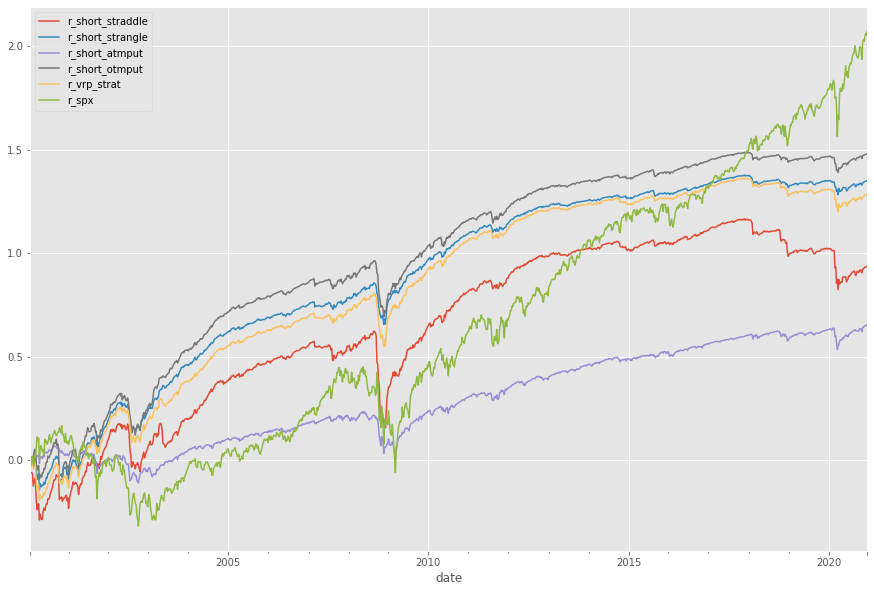

In [102]:
short_vol_df[strats].apply(lambda x: 1+x).cumprod().resample('W').last().pct_change().cumsum().plot()